# Extract tropopause levels from NCEP Global Reanalyses using xarray

The goal is to use outputs from NCEP Global Reanalyses to calculate and extract information about the global distribution of the altitude of the tropopause. We use the [xarray](http://xarray.pydata.org) Python package for handling the data (including either local or remote loading).



In [16]:
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

%matplotlib inline

## Get the monthly mean values of pressure at the tropopause

We access the data (i.e., the monthly mean values of the tropopause pressure) via [OPeNDAP](http://www.opendap.org/). We only need to specify the URL of the dataset, and `xarray` loads it as a `xarray.Dataset` object.

In [2]:
noaa_baseurl = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets"
ncep_src = "ncep.reanalysis.derived"
tropp_data_src = "tropopause/pres.tropp.mon.mean.nc"

tropp_data_url = "/".join([noaa_baseurl, ncep_src, tropp_data_src])

tropp_mon_mean = xr.open_dataset(tropp_data_url)

View information about the pressure variable (the only one in the dataset). The array has 3 dimensions: lat, lon and time (each month since 01-1948).

In [3]:
tropp_mon_mean.pres

<xarray.DataArray 'pres' (time: 841, lat: 73, lon: 144)>
[8840592 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 1948-03-01 ...
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
Attributes:
    long_name:     Monthly Mean of Pressure
    units:         millibars
    precision:     2
    var_desc:      Pressure
    level_desc:    Tropopause
    statistic:     Mean
    parent_stat:   Other
    valid_range:   [-102.19999695  102.19999695]
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [  85.          419.70001221]
    _ChunkSizes:   [  1  73 144]

Get the time span of the dataset

In [4]:
print([tropp_mon_mean.time.min(), tropp_mon_mean.time.max()])

[<xarray.DataArray 'time' ()>
array(-694310400000000000, dtype='datetime64[ns]'), <xarray.DataArray 'time' ()>
array(1514764800000000000, dtype='datetime64[ns]')]


## Get the monthly mean values of sea level pressure

The cells below perform the same operations as for the pressure at the tropopause.

In [5]:
slp_data_src = "surface/slp.mon.mean.nc"
slp_data_url = "/".join([noaa_baseurl, ncep_src, slp_data_src])

slp_mon_mean = xr.open_dataset(slp_data_url)

In [6]:
slp_mon_mean.slp

<xarray.DataArray 'slp' (time: 841, lat: 73, lon: 144)>
[8840592 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 1948-03-01 ...
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
Attributes:
    long_name:     Sea Level Pressure
    valid_range:   [  870.  1150.]
    units:         millibars
    precision:     1
    var_desc:      Sea Level Pressure
    level_desc:    Sea Level
    statistic:     Mean
    parent_stat:   Other
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [  955.56085205  1082.55822754]
    _ChunkSizes:   [  1  73 144]

## Get the monthly mean values of potential temperature

The potential temperature is calculated at the sigma level 995.

In [7]:
pottmp_data_src = "surface/pottmp.sig995.mon.mean.nc"
pottmp_data_url = "/".join([noaa_baseurl, ncep_src, pottmp_data_src])

pottmp_mon_mean = xr.open_dataset(pottmp_data_url)

In [8]:
pottmp_mon_mean.pottmp

<xarray.DataArray 'pottmp' (time: 841, lat: 73, lon: 144)>
[8840592 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 1948-03-01 ...
Attributes:
    long_name:     Monthly mean potential temperature at sigma level 995
    units:         degK
    precision:     1
    GRIB_id:       13
    GRIB_name:     POT
    var_desc:      Potential Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    valid_range:   [ 150.  900.]
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [ 214.59985352  334.69995117]
    _ChunkSizes:   [  1  73 144]

## Calculate the altitude of the tropopause given the sea level pressure, the tropopause pressure and the potential temperature

We use the following simple model of pressure vs. altitude (assuming a column of dry air that behaves like a perfect gas):

$$ p_t \approx p_0 \left(1 - \frac{g \cdot h_t}{c_p \cdot T_0}\right)^{\frac{c_p \cdot M}{R}} \approx p_0 \left(1 - 0.0065 \frac{h_t}{T_0}\right)^{5.2561} $$

where $p_t$ is the pressure at the tropopause (Pa), $p_0$ is the pressure at sea level, $h_t$ is the altitude of the tropopause (m), $T_0$ is the potential temperature (K), $c_p$ is the constant pressure specific heat ($\sim$ 1007 J kg$^{-1}$ K$^{-1}$), $g$ is the Earth-surface gravitational acceleration (9.81 m s$^{-2}$), $M$ is the molar mass of dry air (0.0289644 kg mol$^{-1}$) and $R$ is the universal gas constant (8.31447 J mol$^{-1}$ K$^{-1}$).

By rearranging the equation, we express $h_t$ as:

$$ h_t \approx \frac{T_0}{0.0065} \left(1 - \left[\frac{p_t}{p_0}\right]^{\frac{1}{5.2561}}\right) $$

Since `xarray` supports broadcasting, it is very simple and straightforward to apply the latter expression to the lat/lon/time `xarray.DataArray` objects imported above. Note however that no data has been loaded into memory so far (only *lazy loading*). As the calculation here requires the access to the data values, the cell below will load the all the data silently (it may thus take some time).

In [9]:
tropp_alt_mon_mean = (
    pottmp_mon_mean.pottmp / 0.0065 *
    (1. - (tropp_mon_mean.pres / slp_mon_mean.slp)**(1. / 5.2561))
)


We add some metadata to the `xarray.DataArray` object

In [10]:
tropp_alt_mon_mean.name = "tropp_alt"

extra_attrs = {
    'long_name': "Monthly mean altitude of the tropopause",
    'units': "m",
    'var_desc': "Altitude", 
    'dataset': "Calculated from CDC Derived NCEP Reanalysis Products",
    'statistic': "Mean",
    'level_desc': "Tropopause"
}
    
tropp_alt_mon_mean.attrs.update(extra_attrs) 

## Extract and plot tropopause altitudes

The tropopause altitudes calculated above consist of monthly mean values in a 3-d array with lat, lon and time (each month since 01-1948) coordinates. We can further extract specific values or statistics from this result.

For example, the cell below calculates the monthly means for the whole period covered by the data. it returns a 3-d array of tropopause altitudes with lat/lon coordinates and a 12-months coordinate.

In [11]:
tropp_alt_12m = tropp_alt_mon_mean.groupby(
    tropp_alt_mon_mean['time.month']
).mean(dim='time')

tropp_alt_12m

<xarray.DataArray 'tropp_alt' (month: 12, lat: 73, lon: 144)>
array([[[ 8149.977556,  8149.977556, ...,  8149.977556,  8149.977556],
        [ 8205.874511,  8213.939486, ...,  8188.038455,  8198.183513],
        ..., 
        [ 8398.040374,  8404.851952, ...,  8383.944816,  8391.591202],
        [ 8396.645121,  8396.645121, ...,  8396.645346,  8396.645346]],

       [[ 7896.618377,  7896.618377, ...,  7896.618377,  7896.618377],
        [ 7967.468451,  7978.407985, ...,  7945.971651,  7956.414974],
        ..., 
        [ 7667.482004,  7671.534687, ...,  7661.674173,  7664.604792],
        [ 7763.349672,  7763.349672, ...,  7763.349672,  7763.349672]],

       ..., 
       [[ 7909.67556 ,  7909.67556 , ...,  7909.67556 ,  7909.67556 ],
        [ 7898.403646,  7905.844154, ...,  7883.393987,  7890.213313],
        ..., 
        [ 9897.873334,  9899.872474, ...,  9893.722201,  9896.223198],
        [ 9857.130498,  9857.130498, ...,  9857.130498,  9857.130498]],

       [[ 8005.880645,  8

We can further extract the latter monthly means at a given lat/lon grid box...

In [12]:
gridbox_lat = 45.0
gridbox_lon = 7.5

tropp_alt_series = tropp_alt_12m.sel(
    lat=gridbox_lat, lon=gridbox_lon
).to_series()

tropp_alt_series

month
1     10571.614736
2     10334.657810
3     10545.117497
4     10622.844724
5     11256.418247
6     11807.427604
7     12367.148199
8     12533.466505
9     12383.652305
10    11990.813333
11    11212.357117
12    10815.336996
Name: tropp_alt, dtype: float64

... or get and plot the complete time series for that grid box

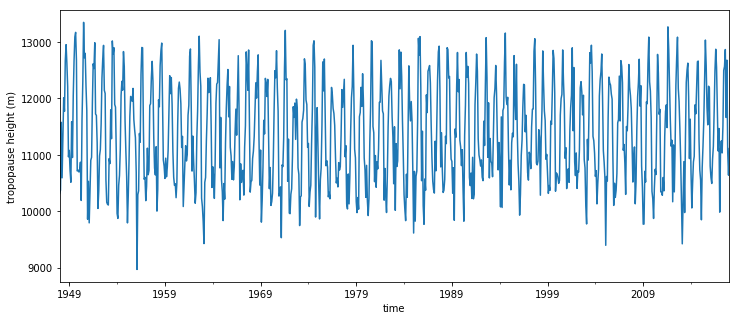

In [18]:
tropp_alt_series_all = tropp_alt_mon_mean.sel(
    lat=gridbox_lat, lon=gridbox_lon
).to_series()

fig, ax = plt.subplots(figsize=(12, 5))

tropp_alt_series_all.plot(ax=ax)

ax.set(ylabel="tropopause height (m)");

Another example: a contour plot of monthly means averaged over the longitude.

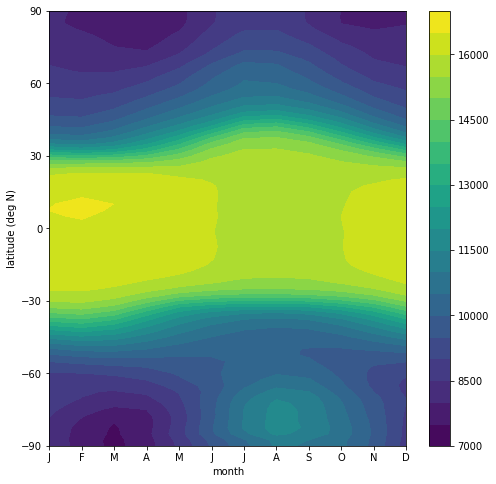

In [22]:
tropp_alt_lon_avg = tropp_alt_12m.mean(dim='lon')

fig, ax = plt.subplots(figsize=(8, 8))

c = ax.contourf(tropp_alt_lon_avg.month,
                tropp_alt_lon_avg.lat,
                tropp_alt_lon_avg.transpose('lat', 'month'),
                20)

plt.colorbar(c)

ax.set(
    xlabel="month", ylabel="latitude (deg N)",
    yticks=range(-90, 110, 30), xticks=range(1,13),
    xticklabels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
);

Extract and plot the longitude averaged monthly mean values of tropopause height for three given latitudes

In [23]:
tropp_alt_lon_avg.sel(lat=[35, 45, 55])

<xarray.DataArray 'tropp_alt' (month: 12, lat: 3)>
array([[ 11502.518421,   9646.556427,   8962.672286],
       [ 11304.718977,   9594.139825,   8917.16879 ],
       [ 11666.867458,   9928.318763,   9070.425248],
       [ 12403.19996 ,  10518.95637 ,   9450.379021],
       [ 13398.066106,  11135.073866,   9904.125121],
       [ 14638.608542,  11829.69431 ,  10479.339963],
       [ 15319.254804,  12848.970311,  10914.369901],
       [ 15345.594078,  13047.910788,  10947.515501],
       [ 15108.23927 ,  12437.165056,  10589.356113],
       [ 14413.085323,  11635.272499,  10027.719067],
       [ 13409.707039,  10685.351505,   9433.75647 ],
       [ 12381.583313,   9997.83282 ,   9106.205061]])
Coordinates:
  * lat      (lat) float32 35.0 45.0 55.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

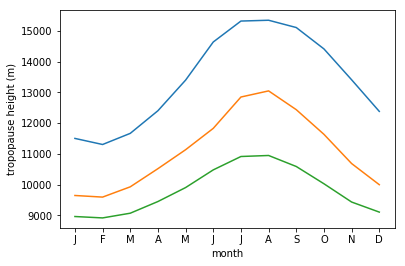

In [24]:
ax = plt.subplot()

for lat in [35, 45, 55]:
    ax.plot(tropp_alt_lon_avg.sel(lat=lat))

ax.set(
    xlabel='month', ylabel='tropopause height (m)', xticks=range(0, 12),
    xticklabels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
);